# ResNet-18 CNN: PyTorch & CIFAR-10

End-to-end programming tutorial including:

1. Dropout (Vanilla ResNet-18 displays a high degree of overfitting)
1. Progress bar - training model
1. Train model with _early stopping criterion_
1. Learning rate scheduler
1. Compare between learning rate scheduler and early stopping criterion


[Reference](https://d2l.ai/chapter_convolutional-modern/resnet.html#fig-residual-block)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os

In [24]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"currently available device: {device}")

currently available device: cuda


In [3]:
# Get number of multiple GPUs (if any)-
print(f"number of available GPUs = {torch.cuda.device_count()}")

number of available GPUs = 1


In [4]:
# Get current GPU-
print(f"Current GPU = {torch.cuda.current_device()}")

Current GPU = 0


In [5]:
# Get name of current GPU-
print(f"Name of current GPU being used = {torch.cuda.get_device_name(torch.cuda.current_device())}")

Name of current GPU being used = Quadro M6000


In [6]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 1.8.0


In [7]:
# Hyper-parameters-
num_epochs = 65
batch_size = 128
learning_rate = 0.01

In [8]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

In [9]:
# Load dataset-
train_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = True,
        download = True, transform = transform_train
        )

test_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = False,
        download = True, transform = transform_test
        )

Files already downloaded and verified
Files already downloaded and verified


In [10]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [11]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [12]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 391 & len(test_loader) = 79


In [13]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(390.625, 78.125)

In [14]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

# Sanity check-
images, labels = next(iter(train_loader))

images.size(), labels.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

### Define _ResNet-18_ architecture:

In [15]:
class ResidualBlock(nn.Module):
    '''
    Residual Block within a ResNet CNN model
    '''
    def __init__(self, input_channels, num_channels, 
                 use_1x1_conv = False, strides = 1,
                 dropout = 0.2):
        # super(ResidualBlock, self).__init__()
        super().__init__()
     
        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = num_channels,
            kernel_size = 3, padding = 1, stride = strides,
            bias = False
            )
        
        self.dropout = nn.Dropout(p = dropout)
        
        self.conv2 = nn.Conv2d(
            in_channels = num_channels, out_channels = num_channels,
            kernel_size = 3, padding = 1, stride = 1,
            bias = False
            )
        
        if use_1x1_conv:
            self.conv3 = nn.Conv2d(
                in_channels = input_channels, out_channels = num_channels,
                kernel_size = 1, stride = strides
                )
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_features = num_channels)
        self.bn2 = nn.BatchNorm2d(num_features = num_channels)
        self.relu = nn.ReLU(inplace = True)

        self.initialize_weights()
        
    
    def forward(self, X):
        Y = self.dropout(F.relu(self.bn1(self.conv1(X))))
        # Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        # Y = self.dropout(F.relu(self.bn2(self.conv2(Y))))
        
        if self.conv3:
            X = self.conv3(X)
            # print(f"X.shape due to 1x1: {X.shape} & Y.shape = {Y.shape}")
        else:
            # print(f"X.shape without 1x1: {X.shape} & Y.shape = {Y.shape}")
            pass
        
        Y += X
        # return F.relu(Y)
        return self.dropout(F.relu(Y))
    
    
    def shape_computation(self, X):
        Y = self.conv1(X)
        print(f"self.conv1(X).shape: {Y.shape}")
        Y = self.conv2(Y)
        print(f"self.conv2(X).shape: {Y.shape}")
        
        if self.conv3:
            h = self.conv3(X)
            print(f"self.conv3(X).shape: {h.shape}")
    

    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

In [16]:
b0 = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d(num_features = 64),
    nn.ReLU()
)

In [17]:
# Sanity check-
b0(images).shape

torch.Size([128, 64, 32, 32])

In [16]:
# del b0

In [18]:
def create_resnet_block(input_filters, output_filters, num_residuals, first_block = False, dropout = 0.2):
    # Python list to hold the created ResNet blocks-
    resnet_blk = []
    
    for i in range(num_residuals):
        if i == 0 and first_block:
            resnet_blk.append(ResidualBlock(input_channels = input_filters, num_channels = output_filters, use_1x1_conv = True, strides = 2, dropout = dropout))
        else:
            resnet_blk.append(ResidualBlock(input_channels = output_filters, num_channels = output_filters, use_1x1_conv = False, strides = 1, dropout = dropout))
    
    return resnet_blk

In [19]:
b1 = nn.Sequential(*create_resnet_block(input_filters = 64, output_filters = 64, num_residuals = 2, first_block = True, dropout = 0.2))
b2 = nn.Sequential(*create_resnet_block(input_filters = 64, output_filters = 128, num_residuals = 2, first_block = True, dropout = 0.3))
b3 = nn.Sequential(*create_resnet_block(input_filters = 128, output_filters = 256, num_residuals = 2, first_block = True, dropout = 0.3))
b4 = nn.Sequential(*create_resnet_block(input_filters = 256, output_filters = 512, num_residuals = 2, first_block = True, dropout = 0.3))

In [20]:
def create_resnet18():
    # Initialize ResNet-18 model-
    model = nn.Sequential(
        b0, b1, b2, b3, b4,
        nn.AdaptiveAvgPool2d(output_size = (1, 1)),
        nn.Flatten(),
        nn.Linear(in_features = 512, out_features = 10)
    )
    
    return model


In [21]:
model = create_resnet18()

In [22]:
# Sanity check-
model(images).shape

torch.Size([128, 10])

In [25]:
# Place model on GPU-
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride

In [26]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64, 64, 1, 1]) has 4096 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([128, 64, 3, 3]) h

In [27]:
print(f"Total number of parameters in VGG-18 CNN = {tot_params}")

Total number of parameters in VGG-18 CNN = 11177290


In [ ]:
'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
'''

In [28]:
# Save random initial weights-
torch.save(model.state_dict(), 'ResNet18_dropout_random_weights.pth')

In [28]:
# Load randomly initialised weights-
# model.load_state_dict(torch.load('ResNet18_random_weights.pth'))

<All keys matched successfully>

In [29]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [30]:
"""
def train_step(model, train_loader):
    running_loss = 0.0
    running_corrects = 0.0

    for batch, (images, labels) in enumerate(train_loader):
        # Attempt to push to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # print(f"batch # = {batch}")

        model.train()

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        J.backward()    # perform backpropagation

        # Updates parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_training_steps}, loss = {J.item():.4f}")
        '''

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = (running_corrects.double() / len(train_dataset)) * 100
    
    return epoch_loss, epoch_acc.cpu().numpy()
    
"""

In [30]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    


In [34]:
"""
def validate_step(model, test_loader):
    total, correct = 0, 0
    running_loss_val = 0.0

    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            images = images.to(device)
            labels = labels.to(device)

            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)

    return epoch_val_loss, val_acc.cpu().numpy()

"""

In [31]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [33]:
# Sanity check-
train_loss, train_acc = train_model_progress(model, train_loader)

Training: : 100%|██████████| 391/391 [04:08<00:00,  1.57batch/s, accuracy=45.5, loss=1.47]


In [34]:
# Sanity check-
val_loss, val_acc = test_model_progress(model, test_loader)

Validation: : 100%|██████████| 79/79 [00:08<00:00,  9.06batch/s, val_acc=56.6, val_loss=1.21]


### Train model _without_ learning rate scheduler, using early-stopping criterion

In [32]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [33]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [34]:
training_history = {}

In [35]:
for epoch in range(num_epochs):

    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break

    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    '''
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VGG18_best_model.pth")
    '''

    # Code for manual Early Stopping:
    # if np.abs(val_loss < best_val_loss) >= minimum_delta:
    if (val_loss < best_val_loss) and \
    (np.abs(val_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet18_best_model.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    

Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.19batch/s, val_acc=11, val_loss=2.96]   



epoch: 1 training loss = 2.2996, training accuracy = 19.64%, val_loss = 2.9611, val_accuracy = 11.01% & LR = 0.0100

Saving model with lowest val_loss = 2.9611



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.01batch/s, val_acc=15.9, val_loss=2.57] 



epoch: 2 training loss = 1.9071, training accuracy = 26.61%, val_loss = 2.5747, val_accuracy = 15.92% & LR = 0.0100

Saving model with lowest val_loss = 2.5747



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.23batch/s, val_acc=28.3, val_loss=2.14] 



epoch: 3 training loss = 1.7700, training accuracy = 31.68%, val_loss = 2.1377, val_accuracy = 28.29% & LR = 0.0100

Saving model with lowest val_loss = 2.1377



Validation: : 100%|██████████| 79/79 [00:05<00:00, 14.66batch/s, val_acc=33.9, val_loss=1.86] 



epoch: 4 training loss = 1.6677, training accuracy = 36.37%, val_loss = 1.8625, val_accuracy = 33.94% & LR = 0.0100

Saving model with lowest val_loss = 1.8625



Validation: : 100%|██████████| 79/79 [00:04<00:00, 17.82batch/s, val_acc=39.3, val_loss=1.71] 



epoch: 5 training loss = 1.5652, training accuracy = 41.00%, val_loss = 1.7129, val_accuracy = 39.34% & LR = 0.0100

Saving model with lowest val_loss = 1.7129



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.54batch/s, val_acc=46.7, val_loss=1.48] 



epoch: 6 training loss = 1.4870, training accuracy = 44.19%, val_loss = 1.4775, val_accuracy = 46.69% & LR = 0.0100

Saving model with lowest val_loss = 1.4775



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.44batch/s, val_acc=47.7, val_loss=1.51] 



epoch: 7 training loss = 1.4029, training accuracy = 47.75%, val_loss = 1.5057, val_accuracy = 47.69% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.63batch/s, val_acc=49.3, val_loss=1.44] 



epoch: 8 training loss = 1.3243, training accuracy = 51.11%, val_loss = 1.4371, val_accuracy = 49.27% & LR = 0.0100

Saving model with lowest val_loss = 1.4371



Validation: : 100%|██████████| 79/79 [00:04<00:00, 17.99batch/s, val_acc=55.6, val_loss=1.28] 



epoch: 9 training loss = 1.2603, training accuracy = 53.71%, val_loss = 1.2837, val_accuracy = 55.60% & LR = 0.0100

Saving model with lowest val_loss = 1.2837



Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.15batch/s, val_acc=58.1, val_loss=1.23] 



epoch: 10 training loss = 1.1910, training accuracy = 56.69%, val_loss = 1.2286, val_accuracy = 58.09% & LR = 0.0100

Saving model with lowest val_loss = 1.2286



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.01batch/s, val_acc=57.4, val_loss=1.24] 



epoch: 11 training loss = 1.1359, training accuracy = 58.87%, val_loss = 1.2431, val_accuracy = 57.39% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 14.94batch/s, val_acc=62.8, val_loss=1.05] 



epoch: 12 training loss = 1.0861, training accuracy = 61.06%, val_loss = 1.0513, val_accuracy = 62.80% & LR = 0.0100

Saving model with lowest val_loss = 1.0513



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.25batch/s, val_acc=62.7, val_loss=1.07] 



epoch: 13 training loss = 1.0379, training accuracy = 63.03%, val_loss = 1.0745, val_accuracy = 62.70% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 14.91batch/s, val_acc=66.1, val_loss=0.992]



epoch: 14 training loss = 0.9958, training accuracy = 64.50%, val_loss = 0.9920, val_accuracy = 66.12% & LR = 0.0100

Saving model with lowest val_loss = 0.9920



Validation: : 100%|██████████| 79/79 [00:04<00:00, 15.83batch/s, val_acc=66.9, val_loss=0.945]



epoch: 15 training loss = 0.9562, training accuracy = 65.85%, val_loss = 0.9451, val_accuracy = 66.89% & LR = 0.0100

Saving model with lowest val_loss = 0.9451



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.45batch/s, val_acc=67.7, val_loss=0.941]



epoch: 16 training loss = 0.9266, training accuracy = 67.12%, val_loss = 0.9406, val_accuracy = 67.68% & LR = 0.0100

Saving model with lowest val_loss = 0.9406



Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.29batch/s, val_acc=65.2, val_loss=1.05] 



epoch: 17 training loss = 0.9001, training accuracy = 67.94%, val_loss = 1.0485, val_accuracy = 65.20% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.05batch/s, val_acc=70.5, val_loss=0.863]



epoch: 18 training loss = 0.8674, training accuracy = 69.23%, val_loss = 0.8632, val_accuracy = 70.54% & LR = 0.0100

Saving model with lowest val_loss = 0.8632



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.05batch/s, val_acc=71.1, val_loss=0.86] 



epoch: 19 training loss = 0.8419, training accuracy = 70.39%, val_loss = 0.8597, val_accuracy = 71.10% & LR = 0.0100

Saving model with lowest val_loss = 0.8597



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.67batch/s, val_acc=69.3, val_loss=0.932]



epoch: 20 training loss = 0.8176, training accuracy = 71.24%, val_loss = 0.9315, val_accuracy = 69.30% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.35batch/s, val_acc=74.8, val_loss=0.748] 



epoch: 21 training loss = 0.7994, training accuracy = 72.03%, val_loss = 0.7476, val_accuracy = 74.76% & LR = 0.0100

Saving model with lowest val_loss = 0.7476



Validation: : 100%|██████████| 79/79 [00:05<00:00, 14.68batch/s, val_acc=74.7, val_loss=0.758] 



epoch: 22 training loss = 0.7776, training accuracy = 72.79%, val_loss = 0.7582, val_accuracy = 74.65% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.36batch/s, val_acc=75.8, val_loss=0.704] 



epoch: 23 training loss = 0.7538, training accuracy = 73.69%, val_loss = 0.7037, val_accuracy = 75.81% & LR = 0.0100

Saving model with lowest val_loss = 0.7037



Validation: : 100%|██████████| 79/79 [00:05<00:00, 14.99batch/s, val_acc=77.4, val_loss=0.674] 



epoch: 24 training loss = 0.7304, training accuracy = 74.72%, val_loss = 0.6745, val_accuracy = 77.39% & LR = 0.0100

Saving model with lowest val_loss = 0.6745



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.58batch/s, val_acc=75.9, val_loss=0.707] 



epoch: 25 training loss = 0.7171, training accuracy = 75.09%, val_loss = 0.7071, val_accuracy = 75.90% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.30batch/s, val_acc=77.9, val_loss=0.66]  



epoch: 26 training loss = 0.6962, training accuracy = 75.57%, val_loss = 0.6596, val_accuracy = 77.92% & LR = 0.0100

Saving model with lowest val_loss = 0.6596



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.42batch/s, val_acc=77.6, val_loss=0.678] 



epoch: 27 training loss = 0.6853, training accuracy = 76.36%, val_loss = 0.6784, val_accuracy = 77.60% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.23batch/s, val_acc=78.8, val_loss=0.623] 



epoch: 28 training loss = 0.6649, training accuracy = 77.07%, val_loss = 0.6232, val_accuracy = 78.82% & LR = 0.0100

Saving model with lowest val_loss = 0.6232



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.57batch/s, val_acc=78.1, val_loss=0.648] 



epoch: 29 training loss = 0.6532, training accuracy = 77.54%, val_loss = 0.6481, val_accuracy = 78.13% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 17.24batch/s, val_acc=79.4, val_loss=0.608] 



epoch: 30 training loss = 0.6424, training accuracy = 77.97%, val_loss = 0.6076, val_accuracy = 79.37% & LR = 0.0100

Saving model with lowest val_loss = 0.6076



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.57batch/s, val_acc=80.7, val_loss=0.568] 



epoch: 31 training loss = 0.6320, training accuracy = 78.19%, val_loss = 0.5680, val_accuracy = 80.69% & LR = 0.0100

Saving model with lowest val_loss = 0.5680



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.04batch/s, val_acc=81.5, val_loss=0.546] 



epoch: 32 training loss = 0.6221, training accuracy = 78.75%, val_loss = 0.5463, val_accuracy = 81.54% & LR = 0.0100

Saving model with lowest val_loss = 0.5463



Validation: : 100%|██████████| 79/79 [00:04<00:00, 17.48batch/s, val_acc=80.3, val_loss=0.585] 



epoch: 33 training loss = 0.6073, training accuracy = 79.17%, val_loss = 0.5846, val_accuracy = 80.31% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.36batch/s, val_acc=83.3, val_loss=0.492] 



epoch: 34 training loss = 0.5982, training accuracy = 79.40%, val_loss = 0.4915, val_accuracy = 83.29% & LR = 0.0100

Saving model with lowest val_loss = 0.4915



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.07batch/s, val_acc=81, val_loss=0.571]   



epoch: 35 training loss = 0.5894, training accuracy = 80.03%, val_loss = 0.5711, val_accuracy = 80.97% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 17.86batch/s, val_acc=81.7, val_loss=0.545] 



epoch: 36 training loss = 0.5770, training accuracy = 80.36%, val_loss = 0.5446, val_accuracy = 81.71% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.46batch/s, val_acc=83, val_loss=0.512]   


epoch: 37 training loss = 0.5687, training accuracy = 80.73%, val_loss = 0.5125, val_accuracy = 82.97% & LR = 0.0100


'EarlyStopping' called!



In [39]:
# Sanity check-
temp_model = create_resnet18()

In [40]:
temp_model.load_state_dict(torch.load('ResNet18_best_model.pth'))

<All keys matched successfully>

In [42]:
# Place model on GPU-
temp_model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride

In [43]:
# Compute performance of 'best' model on validation data-
val_loss, val_acc = test_model_progress(temp_model, test_loader)

Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.34batch/s, val_acc=83.3, val_loss=0.492] 


In [44]:
print(f"ResNet-18 'best' model (dropout with early stopping) metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

ResNet-18 'best' model (dropout with early stopping) metrics: val_loss = 0.4915 & val_acc = 83.29%


In [45]:
training_history.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37])

In [46]:
training_history[2].keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [47]:
training_history[2]['val_acc']

array(15.92, dtype=float32)

In [48]:
import pickle

In [49]:
with open("ResNet18_dropout_early_stopping_training_history.pkl", "wb") as file:
    pickle.dump(training_history, file)

In [37]:
# Save trained weights-
# torch.save(model.state_dict(), 'ResNet18_dropout_trained_weights.pth')

In [50]:
del temp_model, model

### Train model with _learning rate scheduler_

- Training dataset = 50000, batch size = 128, number of training steps/iterations = 50000 / 128 = 391

- Initial learning rate warmup: 391 x 10 = 3910 steps or, 10 epochs at LR = 0.1

- Until 25th epoch or, 9775 steps use LR = 0.1

- From 26th epoch until 40th epoch or, 15640 steps use LR = 0.01

- From 41st epoch until 50th epoch or, 19550 steps use LR = 0.001

- From 51st epoch until 60th epoch use LR = 0.0001

In [51]:
boundaries = [9775, 15640, 19550]
values = [0.1, 0.01, 0.001, 0.0001]

In [53]:
def decay_function(step, boundaries = [9775, 15640, 19550], values = [0.1, 0.01, 0.001, 0.0001]):
    '''
    1 epoch has 391 steps/iterations using batch size used above.
    
    Until 25th epochs, or 25 x 391 = 9775 steps, use lr = 0.1
    From 26th epoch until 40th epoch, or 15640 steps use LR = 0.01
    From 41st epoch until 50th epoch or, 19550 steps use LR = 0.001
    From 51st epoch until 60th epoch use LR = 0.0001
    '''
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [20]:
"""
def decay_function(step, boundaries = [15640, 19550], values = [0.01, 0.001, 0.0001]):
    '''
    1 epoch has 391 steps/iterations using batch size used above.
    
    Until 40 epochs, or 40 x 391 = 15640 steps, use lr = 0.01
    Until 50 epochs, or 50 x 391 = 19550 steps, use lr = 0.001
    
    For any remaining steps, use lr = 0.0001
    '''
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]
"""

In [ ]:
# decay_function(step = 2, boundaries = [0, 2, 4, 6, 8, 10], values = [10, 15, 20, 30, 40, 50, 60])

In [54]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr


In [55]:
# 391 x 10 = 3910 steps (or, 10 epochs) is learning rate warmup
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 3910,
    decay_func = decay_function
)

In [56]:
step = 0

In [57]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    


In [58]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [59]:
# Initialize and load random weights from before-
model = create_resnet18()

In [60]:
# Load randomly initialised weights-
model.load_state_dict(torch.load('ResNet18_dropout_random_weights.pth'))

<All keys matched successfully>

In [61]:
# Place model on GPU (if available)-
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride

In [62]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

In [63]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [65]:
training_history_lr_scheduler = {}

In [64]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [66]:
for epoch in range(num_epochs):

    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet18_lr_schedule_best_model.pth")
    


Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.14batch/s, val_acc=10.1, val_loss=3.59] 



epoch: 1 training loss = 2.3634, training accuracy = 16.40%, val_loss = 3.5946, val_accuracy = 10.05% & LR = 0.0100

Saving model with lowest val_loss = 3.5946



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.38batch/s, val_acc=17.5, val_loss=2.56] 



epoch: 2 training loss = 1.9554, training accuracy = 25.55%, val_loss = 2.5627, val_accuracy = 17.52% & LR = 0.0200

Saving model with lowest val_loss = 2.5627



Validation: : 100%|██████████| 79/79 [00:04<00:00, 15.88batch/s, val_acc=31.4, val_loss=2.02] 



epoch: 3 training loss = 1.7319, training accuracy = 34.33%, val_loss = 2.0238, val_accuracy = 31.42% & LR = 0.0300

Saving model with lowest val_loss = 2.0238



Validation: : 100%|██████████| 79/79 [00:05<00:00, 14.30batch/s, val_acc=45, val_loss=1.48]   



epoch: 4 training loss = 1.5747, training accuracy = 40.70%, val_loss = 1.4767, val_accuracy = 44.97% & LR = 0.0400

Saving model with lowest val_loss = 1.4767



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.68batch/s, val_acc=45.8, val_loss=1.63] 



epoch: 5 training loss = 1.4150, training accuracy = 47.51%, val_loss = 1.6270, val_accuracy = 45.80% & LR = 0.0500



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.56batch/s, val_acc=56.3, val_loss=1.28] 



epoch: 6 training loss = 1.2696, training accuracy = 54.58%, val_loss = 1.2789, val_accuracy = 56.28% & LR = 0.0600

Saving model with lowest val_loss = 1.2789



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.16batch/s, val_acc=56.7, val_loss=1.27] 



epoch: 7 training loss = 1.1555, training accuracy = 58.84%, val_loss = 1.2665, val_accuracy = 56.70% & LR = 0.0700

Saving model with lowest val_loss = 1.2665



Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.10batch/s, val_acc=64.3, val_loss=1.03] 



epoch: 8 training loss = 1.0656, training accuracy = 62.46%, val_loss = 1.0349, val_accuracy = 64.28% & LR = 0.0800

Saving model with lowest val_loss = 1.0349



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.46batch/s, val_acc=58.5, val_loss=1.25] 



epoch: 9 training loss = 1.0219, training accuracy = 64.31%, val_loss = 1.2453, val_accuracy = 58.53% & LR = 0.0900



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.39batch/s, val_acc=70.3, val_loss=0.873]



epoch: 10 training loss = 0.9835, training accuracy = 65.85%, val_loss = 0.8730, val_accuracy = 70.27% & LR = 0.1000

Saving model with lowest val_loss = 0.8730



Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.09batch/s, val_acc=69.5, val_loss=0.878]



epoch: 11 training loss = 0.9376, training accuracy = 67.67%, val_loss = 0.8780, val_accuracy = 69.47% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.61batch/s, val_acc=70.5, val_loss=0.872]



epoch: 12 training loss = 0.9108, training accuracy = 68.96%, val_loss = 0.8716, val_accuracy = 70.52% & LR = 0.1000

Saving model with lowest val_loss = 0.8716



Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.33batch/s, val_acc=71.1, val_loss=0.845]



epoch: 13 training loss = 0.8749, training accuracy = 70.05%, val_loss = 0.8448, val_accuracy = 71.11% & LR = 0.1000

Saving model with lowest val_loss = 0.8448



Validation: : 100%|██████████| 79/79 [00:05<00:00, 14.90batch/s, val_acc=71.5, val_loss=0.854]



epoch: 14 training loss = 0.8458, training accuracy = 71.11%, val_loss = 0.8540, val_accuracy = 71.55% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.16batch/s, val_acc=74.2, val_loss=0.755] 



epoch: 15 training loss = 0.8264, training accuracy = 71.82%, val_loss = 0.7554, val_accuracy = 74.21% & LR = 0.1000

Saving model with lowest val_loss = 0.7554



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.69batch/s, val_acc=74, val_loss=0.78]   



epoch: 16 training loss = 0.8160, training accuracy = 72.22%, val_loss = 0.7795, val_accuracy = 73.98% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:05<00:00, 14.88batch/s, val_acc=73.4, val_loss=0.797]



epoch: 17 training loss = 0.7920, training accuracy = 73.04%, val_loss = 0.7971, val_accuracy = 73.44% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.34batch/s, val_acc=72.5, val_loss=0.832]



epoch: 18 training loss = 0.7896, training accuracy = 73.22%, val_loss = 0.8317, val_accuracy = 72.52% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.60batch/s, val_acc=74.8, val_loss=0.733] 



epoch: 19 training loss = 0.7753, training accuracy = 73.76%, val_loss = 0.7325, val_accuracy = 74.84% & LR = 0.1000

Saving model with lowest val_loss = 0.7325



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.42batch/s, val_acc=72.6, val_loss=0.803]



epoch: 20 training loss = 0.7708, training accuracy = 73.75%, val_loss = 0.8031, val_accuracy = 72.64% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.45batch/s, val_acc=68.7, val_loss=1.06] 



epoch: 21 training loss = 0.7626, training accuracy = 74.36%, val_loss = 1.0631, val_accuracy = 68.71% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 17.99batch/s, val_acc=75.1, val_loss=0.738] 



epoch: 22 training loss = 0.7536, training accuracy = 74.50%, val_loss = 0.7383, val_accuracy = 75.12% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.12batch/s, val_acc=74.9, val_loss=0.771] 



epoch: 23 training loss = 0.7561, training accuracy = 74.31%, val_loss = 0.7706, val_accuracy = 74.94% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.12batch/s, val_acc=73.9, val_loss=0.784]



epoch: 24 training loss = 0.7472, training accuracy = 74.69%, val_loss = 0.7841, val_accuracy = 73.86% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.58batch/s, val_acc=74.4, val_loss=0.793]



epoch: 25 training loss = 0.7403, training accuracy = 74.93%, val_loss = 0.7929, val_accuracy = 74.41% & LR = 0.1000



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.26batch/s, val_acc=85.2, val_loss=0.437] 



epoch: 26 training loss = 0.5666, training accuracy = 80.92%, val_loss = 0.4370, val_accuracy = 85.15% & LR = 0.0100

Saving model with lowest val_loss = 0.4370



Validation: : 100%|██████████| 79/79 [00:05<00:00, 14.58batch/s, val_acc=85.3, val_loss=0.438] 



epoch: 27 training loss = 0.5119, training accuracy = 82.67%, val_loss = 0.4380, val_accuracy = 85.30% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.23batch/s, val_acc=86.1, val_loss=0.412] 



epoch: 28 training loss = 0.4944, training accuracy = 83.29%, val_loss = 0.4120, val_accuracy = 86.12% & LR = 0.0100

Saving model with lowest val_loss = 0.4120



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.40batch/s, val_acc=86.2, val_loss=0.411] 



epoch: 29 training loss = 0.4834, training accuracy = 83.50%, val_loss = 0.4112, val_accuracy = 86.20% & LR = 0.0100

Saving model with lowest val_loss = 0.4112



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.10batch/s, val_acc=86.4, val_loss=0.405] 



epoch: 30 training loss = 0.4642, training accuracy = 84.32%, val_loss = 0.4048, val_accuracy = 86.38% & LR = 0.0100

Saving model with lowest val_loss = 0.4048



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.38batch/s, val_acc=86.2, val_loss=0.403] 



epoch: 31 training loss = 0.4569, training accuracy = 84.42%, val_loss = 0.4028, val_accuracy = 86.17% & LR = 0.0100

Saving model with lowest val_loss = 0.4028



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.26batch/s, val_acc=86.9, val_loss=0.395] 



epoch: 32 training loss = 0.4503, training accuracy = 84.73%, val_loss = 0.3945, val_accuracy = 86.88% & LR = 0.0100

Saving model with lowest val_loss = 0.3945



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.21batch/s, val_acc=87.1, val_loss=0.384] 



epoch: 33 training loss = 0.4430, training accuracy = 84.79%, val_loss = 0.3839, val_accuracy = 87.09% & LR = 0.0100

Saving model with lowest val_loss = 0.3839



Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.14batch/s, val_acc=87.1, val_loss=0.383] 



epoch: 34 training loss = 0.4361, training accuracy = 85.15%, val_loss = 0.3829, val_accuracy = 87.14% & LR = 0.0100

Saving model with lowest val_loss = 0.3829



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.35batch/s, val_acc=87, val_loss=0.381]   



epoch: 35 training loss = 0.4286, training accuracy = 85.31%, val_loss = 0.3807, val_accuracy = 86.97% & LR = 0.0100

Saving model with lowest val_loss = 0.3807



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.51batch/s, val_acc=87.2, val_loss=0.382] 



epoch: 36 training loss = 0.4242, training accuracy = 85.51%, val_loss = 0.3820, val_accuracy = 87.23% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:04<00:00, 17.15batch/s, val_acc=86.5, val_loss=0.401] 



epoch: 37 training loss = 0.4221, training accuracy = 85.56%, val_loss = 0.4014, val_accuracy = 86.45% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.63batch/s, val_acc=88.3, val_loss=0.352] 



epoch: 38 training loss = 0.4190, training accuracy = 85.85%, val_loss = 0.3522, val_accuracy = 88.29% & LR = 0.0100

Saving model with lowest val_loss = 0.3522



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.70batch/s, val_acc=87.7, val_loss=0.367] 



epoch: 39 training loss = 0.4093, training accuracy = 86.11%, val_loss = 0.3665, val_accuracy = 87.70% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.46batch/s, val_acc=87.4, val_loss=0.369] 



epoch: 40 training loss = 0.4021, training accuracy = 86.25%, val_loss = 0.3695, val_accuracy = 87.36% & LR = 0.0100



Validation: : 100%|██████████| 79/79 [00:05<00:00, 14.74batch/s, val_acc=88.9, val_loss=0.333] 



epoch: 41 training loss = 0.3703, training accuracy = 87.32%, val_loss = 0.3334, val_accuracy = 88.88% & LR = 0.0010

Saving model with lowest val_loss = 0.3334



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.50batch/s, val_acc=88.8, val_loss=0.332] 



epoch: 42 training loss = 0.3622, training accuracy = 87.53%, val_loss = 0.3318, val_accuracy = 88.80% & LR = 0.0010

Saving model with lowest val_loss = 0.3318



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.21batch/s, val_acc=89.1, val_loss=0.325] 



epoch: 43 training loss = 0.3593, training accuracy = 87.76%, val_loss = 0.3254, val_accuracy = 89.09% & LR = 0.0010

Saving model with lowest val_loss = 0.3254



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.01batch/s, val_acc=89, val_loss=0.326]   



epoch: 44 training loss = 0.3540, training accuracy = 87.91%, val_loss = 0.3258, val_accuracy = 89.01% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.38batch/s, val_acc=89.1, val_loss=0.324] 



epoch: 45 training loss = 0.3549, training accuracy = 87.83%, val_loss = 0.3242, val_accuracy = 89.15% & LR = 0.0010

Saving model with lowest val_loss = 0.3242



Validation: : 100%|██████████| 79/79 [00:04<00:00, 17.64batch/s, val_acc=88.8, val_loss=0.33]  



epoch: 46 training loss = 0.3491, training accuracy = 88.05%, val_loss = 0.3304, val_accuracy = 88.77% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.04batch/s, val_acc=89, val_loss=0.332]   



epoch: 47 training loss = 0.3524, training accuracy = 87.91%, val_loss = 0.3318, val_accuracy = 88.97% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.14batch/s, val_acc=89.4, val_loss=0.322] 



epoch: 48 training loss = 0.3447, training accuracy = 88.16%, val_loss = 0.3216, val_accuracy = 89.39% & LR = 0.0010

Saving model with lowest val_loss = 0.3216



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.18batch/s, val_acc=89.2, val_loss=0.322] 



epoch: 49 training loss = 0.3422, training accuracy = 88.32%, val_loss = 0.3216, val_accuracy = 89.22% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.58batch/s, val_acc=89.2, val_loss=0.322] 



epoch: 50 training loss = 0.3436, training accuracy = 88.33%, val_loss = 0.3220, val_accuracy = 89.25% & LR = 0.0010



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.25batch/s, val_acc=89.3, val_loss=0.316] 



epoch: 51 training loss = 0.3420, training accuracy = 88.37%, val_loss = 0.3159, val_accuracy = 89.35% & LR = 0.0001

Saving model with lowest val_loss = 0.3159



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.42batch/s, val_acc=89.5, val_loss=0.319] 



epoch: 52 training loss = 0.3365, training accuracy = 88.48%, val_loss = 0.3186, val_accuracy = 89.46% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 15.85batch/s, val_acc=89.4, val_loss=0.318] 



epoch: 53 training loss = 0.3377, training accuracy = 88.32%, val_loss = 0.3183, val_accuracy = 89.42% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.47batch/s, val_acc=89.3, val_loss=0.319] 



epoch: 54 training loss = 0.3374, training accuracy = 88.44%, val_loss = 0.3187, val_accuracy = 89.34% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.44batch/s, val_acc=89.4, val_loss=0.317] 



epoch: 55 training loss = 0.3331, training accuracy = 88.60%, val_loss = 0.3174, val_accuracy = 89.42% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 15.90batch/s, val_acc=89.4, val_loss=0.318] 



epoch: 56 training loss = 0.3331, training accuracy = 88.66%, val_loss = 0.3181, val_accuracy = 89.37% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.76batch/s, val_acc=89.5, val_loss=0.32]  



epoch: 57 training loss = 0.3322, training accuracy = 88.50%, val_loss = 0.3204, val_accuracy = 89.45% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.46batch/s, val_acc=89.4, val_loss=0.318] 



epoch: 58 training loss = 0.3309, training accuracy = 88.71%, val_loss = 0.3181, val_accuracy = 89.41% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.25batch/s, val_acc=89.5, val_loss=0.317] 



epoch: 59 training loss = 0.3343, training accuracy = 88.49%, val_loss = 0.3173, val_accuracy = 89.49% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 16.05batch/s, val_acc=89.4, val_loss=0.318] 



epoch: 60 training loss = 0.3365, training accuracy = 88.54%, val_loss = 0.3182, val_accuracy = 89.38% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.42batch/s, val_acc=89.3, val_loss=0.322] 



epoch: 61 training loss = 0.3329, training accuracy = 88.62%, val_loss = 0.3217, val_accuracy = 89.35% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.11batch/s, val_acc=89.4, val_loss=0.319] 



epoch: 62 training loss = 0.3330, training accuracy = 88.53%, val_loss = 0.3194, val_accuracy = 89.43% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 15.83batch/s, val_acc=89.5, val_loss=0.316] 



epoch: 63 training loss = 0.3347, training accuracy = 88.56%, val_loss = 0.3164, val_accuracy = 89.45% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:04<00:00, 17.86batch/s, val_acc=89.6, val_loss=0.316] 



epoch: 64 training loss = 0.3348, training accuracy = 88.40%, val_loss = 0.3160, val_accuracy = 89.60% & LR = 0.0001



Validation: : 100%|██████████| 79/79 [00:05<00:00, 15.57batch/s, val_acc=89.4, val_loss=0.319] 


epoch: 65 training loss = 0.3361, training accuracy = 88.41%, val_loss = 0.3188, val_accuracy = 89.44% & LR = 0.0001



In [66]:
# Save model from last training epoch if it's better than 'best' model-
# torch.save(model.state_dict(), "ResNet18_last_epoch_model.pth")

In [67]:
# Initialize and load 'best' model achieved so far-
best_model = create_resnet18()

In [68]:
# Load randomly initialised weights-
best_model.load_state_dict(torch.load('ResNet18_lr_schedule_best_model.pth'))

<All keys matched successfully>

In [69]:
# Place model on GPU (if available)-
best_model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride

In [70]:
# Compute performance of 'best' model on validation data-
val_loss, val_acc = test_model_progress(best_model, test_loader)

Validation: : 100%|██████████| 79/79 [00:04<00:00, 18.49batch/s, val_acc=89.3, val_loss=0.316] 


In [71]:
print(f"ResNet-18 'best' model (dropout) metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

ResNet-18 'best' model (dropout) metrics: val_loss = 0.3159 & val_acc = 89.35%


In [72]:
del best_model

### Observation:

For this particular experiment, it seems that using ```val_loss``` as the metric to save the _best_ model is not the optimum choice.

_Highest validation accuracy_ achieved = 90.29%.

_Dropout_ controls the overfitting nicely as the difference training and validation metrics are quite close.

In [73]:
# Sanity check-
training_history_lr_scheduler.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [74]:
training_history_lr_scheduler[12].keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [76]:
import pickle

In [75]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet18_dropout_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

### Training Visualizations

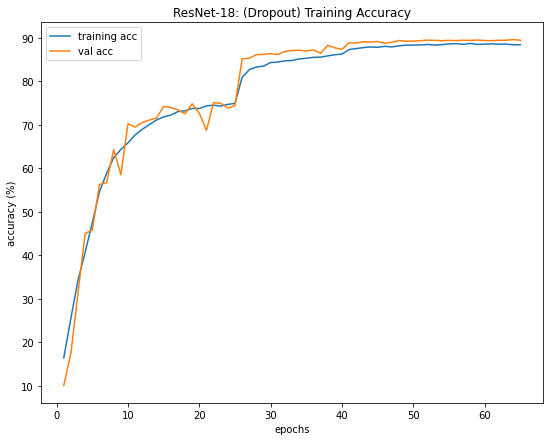

In [76]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-18: (Dropout) Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

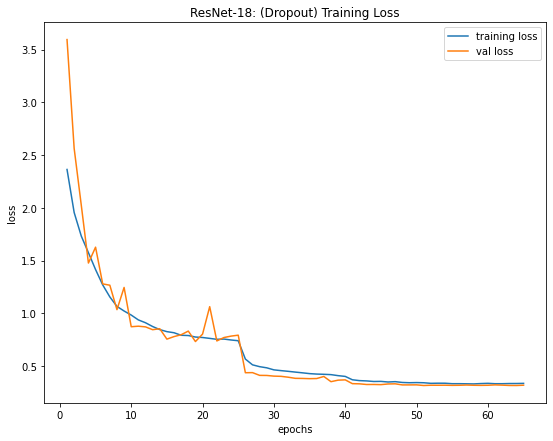

In [77]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-18: (Dropout) Training Loss")
plt.show()

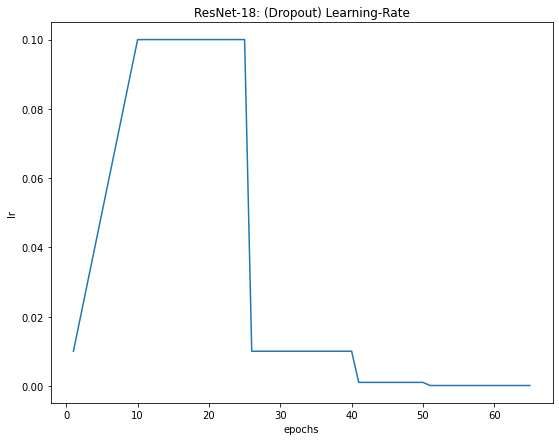

In [78]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-18: (Dropout) Learning-Rate")
plt.show()